# בַּיּוֹם הַהוּא Phrasal Analysis, slots

In [3]:
# import standard modules
import re
import sys
import pickle
import json
import collections
import pandas as pd
import numpy as np
from textwrap import dedent
from pathlib import Path
import matplotlib.pyplot as plt
from bidi import algorithm
import seaborn as sns
from IPython.display import display, display_html, HTML

# import TF
from tf.fabric import Fabric
from tf.app import use

# import custom modules
from kingham_thesis.stats.significance import apply_deltaP
from kingham_thesis.visualization.plotting import heatmap
import kingham_thesis.nav_tree as nt

In [6]:
DATA = "/Users/cody/github/BH_time_collocations/results/parsing/phrase_parsings.json"

In [7]:
# configure figure saves

EXPORT_NEW_PLOTS = False
RESULT_PLOT_DIR = Path("/Users/cody/Library/Mobile Documents/com~apple~CloudDocs/dissertation/cx_pilot_2022/result_plots")

def format_plot_fname(name):
    fname = f'{name}.pdf' if not name.endswith('.pdf') else name
    return RESULT_PLOT_DIR.joinpath(fname)

In [8]:
with open(DATA, 'r') as infile:
    phrase_parsings = json.load(infile)

In [9]:
bhsa = use('etcbc/bhsa', version='c')
F, E, T, L = (getattr(bhsa.api, method) for method in "FETL")

## Brief inspection of parsed phrases data

In [10]:
parsed_set = set(int(ph) for ph in phrase_parsings)
full_set = set(F.otype.s('phrase'))

In [11]:
len(full_set)

253207

In [12]:
len(parsed_set & full_set)

112989

In [13]:
len(full_set - parsed_set)

140218

In [14]:
T.text([1, 2], fmt='text-orig-plain')

'בראשׁית '

## Take samples for parsed phrases data

Use the phrase parsings to derive samples.

In [15]:
data_rows = []
unparsed = []

def demon_dist(word):
    """Get the distance of a demonstrative."""
    lex = F.lex.v(word)
    demon_map = { 
            'Z>T': 'near',
            'HJ>': 'far',
            'HMH': 'far',
            '>LH': 'near',
            'HM': 'far',
            'HW>': 'far',
            'ZH': 'near',
            '>L===': 'near',
            'LZH': 'near',
            'LZ': 'near',
            'HNH=': 'far',
            'LZW': 'near',
    }
    try:
        return demon_map[lex]
    except KeyError:
        raise Exception(word, T.text(word), F.lex.v(word))

shin_match = re.compile('\u05e9\u05c1')
sin_match = re.compile('\u05e9\u05c2')

def fix_dots(string):
    string = shin_match.sub('שׁ', string)
    string = sin_match.sub('שׂ', string)
    return string

def get_lex_utf8(slot_node):
    text = F.lex_utf8.v(slot_node)
    text = fix_dots(text)
    return text

def parse_appo_cat(appo):
    """Provide a tag for an appositive."""
    if F.ls.v(appo) == 'ordn':
        return 'ordn'
    elif F.pdp.v(appo) == 'prde':
        dist = demon_dist(appo)
        return f'demon_{dist}'
    elif F.pdp.v(appo) == 'adjv':
        return 'adjv'

def get_text(list_of_nodes):
    try:
        return '־'.join(get_lex_utf8(w) for w in list_of_nodes)
    except:
        raise Exception(list_of_nodes)

    
for phrase, data in phrase_parsings.items():
    phrase = int(phrase)
    parse = data['parse']
    composite_pps = []
    head = nt.get_head(parse)
    is_appo = 0
    clause = L.u(phrase, 'clause')[0]
    slots = L.d(phrase, 'word')
    verse_node = L.u(phrase, 'verse')[0]
    book, chapter, verse = T.sectionFromNode(phrase)
    ref = f'{book} {chapter}:{verse}'
    function = F.function.v(phrase)
    
    appo_head = None
    appo_head_lex = None
    appo_head_pdp = None
    appo_head_cat = None
    
    if function == 'Modi':
        continue
    
    # skip coordinate phrases
    if parse[-1] == 'PARA':
        continue
    
    # NB: The try-catch here will result in all single-word phrases being ignored;
    # thus this analysis will be performed on multi-word phrases only
    try:
        for source, target, cx in nt.get_head_path(parse):
            
            if cx == 'PP':
                pp_slots = list(nt.get_slots(source))
                composite_pps.extend(w for w in pp_slots)
            elif cx == 'APPO':
                try:
                    source_cx = source[-1]
                    target_cx = target[-1]
                    if source_cx == 'DEF' and target_cx == 'DEF':
                        is_appo = 1
                        appo_head = nt.get_head(source)
                except TypeError:
                    pass
        composite_pp = get_text(composite_pps) or 'Ø'

        if appo_head:
            appo_head_lex = get_lex_utf8(appo_head)
            appo_head_pdp = F.pdp.v(appo_head)
            appo_head_cat = parse_appo_cat(appo_head)
    
        
        data_rows.append({
            'ph_node': phrase,
            'ref': ref,
            'book': book,
            'ph_text': T.text(phrase),
            'verse_text': T.text(verse_node),
            'function': function,
            'clause_node': clause,
            'clause_text': T.text(clause),
            'PP': composite_pp,
            'PP_bin': 0 if composite_pp == 'Ø' else 1,
            'is_appo': is_appo,
            'head_lex': get_lex_utf8(head),
            'appo_head_lex': appo_head_lex,
            'appo_head_pdp': appo_head_pdp,
            'appo_head_cat': appo_head_cat,
        })
    except ValueError:
        unparsed.append((phrase, data))

In [16]:
df = pd.DataFrame(data_rows)

In [17]:
df['appo_head_lex'].value_counts()

זה       552
הוא      276
אלה      204
זאת      183
היא      107
        ... 
חדשׁ        1
שׂמאלי      1
גד         1
חזק        1
פרץ        1
Name: appo_head_lex, Length: 119, dtype: int64

In [18]:
df['head_lex'].value_counts()

יהוה     1954
בן       1706
יום      1701
ארץ      1530
מלך      1145
         ... 
כנען        1
סכן         1
בקיע        1
שׁוע         1
יואחז       1
Name: head_lex, Length: 3439, dtype: int64

In [19]:
prep_appo = df[
    (df.PP_bin == 1)
    & (df.is_appo == 1)
]

prep_appo.shape

(1579, 15)

In [20]:
df.head()

,ph_node,ref,book,ph_text,verse_text,function,clause_node,clause_text,PP,PP_bin,is_appo,head_lex,appo_head_lex,appo_head_pdp,appo_head_cat
0,651542,Genesis 1:1,Genesis,בְּרֵאשִׁ֖ית,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,Time,427553,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,ב,1,0,ראשׁית,None,None,None
1,651547,Genesis 1:2,Genesis,הָאָ֗רֶץ,וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֨הוּ֙ וָבֹ֔הוּ וְחֹ֖שֶׁך...,Subj,427554,וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֨הוּ֙ וָבֹ֔הוּ,Ø,0,0,ארץ,None,None,None
2,651552,Genesis 1:2,Genesis,עַל־פְּנֵ֣י תְהֹ֑ום,וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֨הוּ֙ וָבֹ֔הוּ וְחֹ֖שֶׁך...,PreC,427555,וְחֹ֖שֶׁךְ עַל־פְּנֵ֣י תְהֹ֑ום,על־פנה,1,0,תהום,None,None,None
3,651554,Genesis 1:2,Genesis,ר֣וּחַ אֱלֹהִ֔ים,וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֨הוּ֙ וָבֹ֔הוּ וְחֹ֖שֶׁך...,Subj,427556,וְר֣וּחַ אֱלֹהִ֔ים מְרַחֶ֖פֶת עַל־פְּנֵ֥י הַמּ...,Ø,0,0,רוח,None,None,None
4,651556,Genesis 1:2,Genesis,עַל־פְּנֵ֥י הַמָּֽיִם׃,וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֨הוּ֙ וָבֹ֔הוּ וְחֹ֖שֶׁך...,Cmpl,427556,וְר֣וּחַ אֱלֹהִ֔ים מְרַחֶ֖פֶת עַל־פְּנֵ֥י הַמּ...,על־פנה,1,0,מים,None,None,None


## EDA sanity checks

In [21]:
display(pd.DataFrame(df.PP.value_counts().head(25)))

,PP
Ø,20015
ב,10572
ל,7407
את,6589
מן,4342
אל,3187
על,3076
כ,1689
עד,574
ל־פנה,554


In [22]:
df.is_appo.value_counts()

0    58951
1     1992
Name: is_appo, dtype: int64

In [23]:
def show_results(results):
    for result, table in results.items():
        display_html(HTML(f'<h3>{result}</h3>'))
        display(table)
        if result.startswith('dp'):
            heatmap(table, annot=True)
            plt.show()
        print()

def run_analysis(df, index=[], columns=[], show=True, sort_by_cols=False, sort_by_rows=False):
    results = {}
    results['pivot'] = pd.pivot_table(
        df,
        index=index,
        columns=columns,
        aggfunc='size',
    )
    results['pivot'].fillna(0, inplace=True)
    if sort_by_cols:
        col_sort = results['pivot'].sum().sort_values(ascending=False).index
        results['pivot'] = results['pivot'][col_sort]
    if sort_by_rows:
        row_sort = results['pivot'].sum(1).sort_values(ascending=False).index
        results['pivot'] = results['pivot'].loc[row_sort]
    results['prop1'] = results['pivot'].div(results['pivot'].sum(1), 0)
    results['prop2'] = results['pivot'].T.div(results['pivot'].T.sum(1), 0)
    results['dp1'] = apply_deltaP(results['pivot'], 0, 1)
    results['dp2'] = apply_deltaP(results['pivot'].T, 0, 1)
    if show:
        show_results(results)
    return results

## Association Test 1: (is_appo x function)

In [24]:
isappo_function = run_analysis(
    df[
        (df.function != 'Modi')
        & (df.PP_bin == 1)
    ],
    index=['is_appo'],
    columns=['function'],
    show=False,
)

pivot_isappo_function = isappo_function['pivot']

pivot_isappo_function

function,Adju,Cmpl,Loca,Objc,PreC,Subj,Time
is_appo,,,,,,,
0,7274,18488,1897,6053,4009,106,1522
1,119,310,45,344,97,7,657


In [25]:
pivot_isappo_function.loc[1].sum()

1579

In [26]:
657 / 1579

0.4160861304623179

In [27]:
pivot_isappo_function.sum().sum()

40928

In [28]:
isappo_function['dp1']

function,Adju,Cmpl,Loca,Objc,PreC,Subj,Time
is_appo,,,,,,,
0,0.109494,0.27352,0.019711,-0.064031,0.040452,-0.001739,-0.377407
1,-0.109494,-0.27352,-0.019711,0.064031,-0.040452,0.001739,0.377407


In [29]:
isappo_function['prop1']

function,Adju,Cmpl,Loca,Objc,PreC,Subj,Time
is_appo,,,,,,,
0,0.184859,0.469847,0.048210,0.153829,0.101883,0.002694,0.038680
1,0.075364,0.196327,0.028499,0.217859,0.061431,0.004433,0.416086


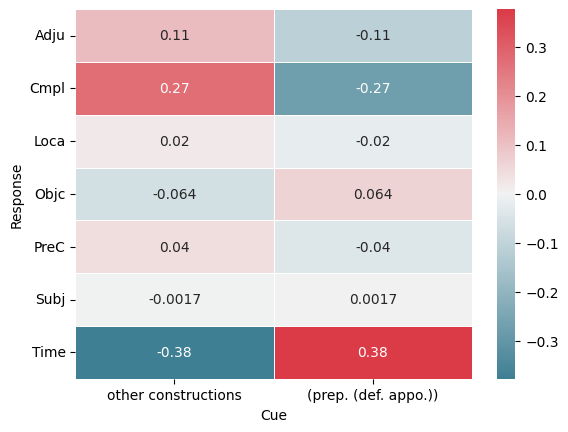

In [30]:
fig, ax = plt.subplots()

heatmap(
    isappo_function['dp1'].T, # transpose for plotting
    square=False, 
    annot=True,
    ax=ax,
)

ax.set_xlabel('Cue')
ax.set_xticklabels([
    'other constructions',
    '(prep. (def. appo.))'
])
ax.set_ylabel('Response')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

if EXPORT_NEW_PLOTS:
    plt.savefig(format_plot_fname('test1_dp1'), format='pdf', bbox_inches='tight')

In [31]:
pivot_isappo_function.T

is_appo,0,1
function,,
Adju,7274,119
Cmpl,18488,310
Loca,1897,45
Objc,6053,344
PreC,4009,97
Subj,106,7
Time,1522,657


In [32]:
isappo_function['dp2']

is_appo,0,1
function,,
Adju,0.027440,-0.027440
Cmpl,0.040852,-0.040852
Loca,0.016175,-0.016175
Objc,-0.018010,0.018010
PreC,0.016624,-0.016624
Subj,-0.023432,0.023432
Time,-0.277720,0.277720


In [33]:
isappo_function['prop2']

is_appo,0,1
function,,
Adju,0.983904,0.016096
Cmpl,0.983509,0.016491
Loca,0.976828,0.023172
Objc,0.946225,0.053775
PreC,0.976376,0.023624
Subj,0.938053,0.061947
Time,0.698486,0.301514


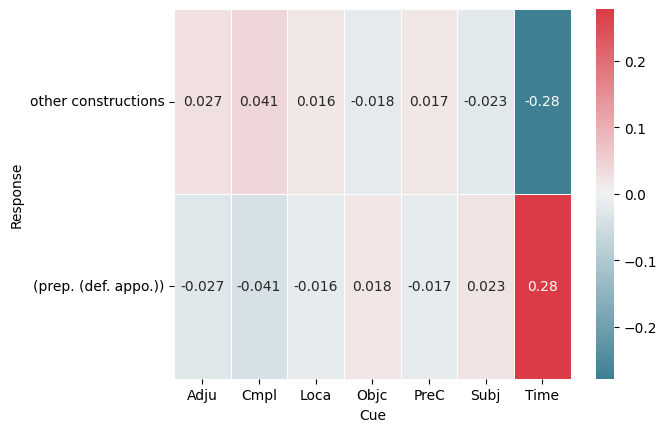

In [35]:
fig, ax = plt.subplots()

heatmap(
    isappo_function['dp2'].T, 
    square=False,
    annot=True,
    ax=ax,
)

ax.set_ylabel('Response')
ax.set_yticklabels([
    'other constructions',
    '(prep. (def. appo.))'
], rotation=0)

ax.set_xlabel('Cue')

if EXPORT_NEW_PLOTS:
    plt.savefig(format_plot_fname('test1_dp2'), format='pdf', bbox_inches='tight')

## Association Test 2: (preposition lex x def_appo)

In [36]:
preplex_defappo = run_analysis(
    df[
        (df.function == 'Time')
        & (df.PP_bin == 1)
    ],
    index=['PP'],
    columns=['is_appo'],
    sort_by_cols=True,
    sort_by_rows=True,
    show=False,
)

In [37]:
preplex_defappo['pivot'].shape

(34, 2)

In [38]:
preplex_defappo['pivot'].head(10)

is_appo,0,1
PP,,
ב,653.0,536.0
עד,228.0,85.0
ל,283.0,7.0
מן,131.0,6.0
אחר,85.0,13.0
כ,39.0,8.0
מן־קץ,19.0,0.0
ב־אחרית,15.0,0.0
בין,11.0,0.0


In [39]:
preplex_defappo['pivot'][1].sum()

657.0

In [40]:
preplex_defappo['pivot'].head(10).to_clipboard()

In [41]:
preplex_defappo['prop1']

is_appo,0,1
PP,,
ב,0.549201,0.450799
עד,0.728435,0.271565
ל,0.975862,0.024138
מן,0.956204,0.043796
אחר,0.867347,0.132653
כ,0.829787,0.170213
מן־קץ,1.000000,0.000000
ב־אחרית,1.000000,0.000000
בין,1.000000,0.000000


In [42]:
preplex_defappo['dp1']

is_appo,0,1
PP,,
ב,-0.328577,0.328577
עד,0.034973,-0.034973
ל,0.319959,-0.319959
מן,0.275009,-0.275009
אחר,0.176814,-0.176814
כ,0.134196,-0.134196
מן־קץ,0.304167,-0.304167
ב־אחרית,0.303604,-0.303604
בין,0.303044,-0.303044


In [43]:
preplex_defappo['prop2']

PP,ב,עד,ל,מן,אחר,כ,מן־קץ,ב־אחרית,בין,מן־קצה,...,מן־ל,ל־מן־ב,ב־ראשׁ,מן־קצת,מן־תחלה,את,עד־אחר,עד־מן,כ־מן,ראשׁ
is_appo,,,,,,,,,,,,,,,,,,,,,
0,0.429041,0.149803,0.185940,0.086071,0.055848,0.025624,0.012484,0.009855,0.007227,0.00657,...,0.000657,0.000657,0.000657,0.000657,0.000657,0.000657,0.000657,0.000657,0.000657,0.000000
1,0.815830,0.129376,0.010654,0.009132,0.019787,0.012177,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001522


In [44]:
preplex_defappo['dp2']

PP,ב,עד,ל,מן,אחר,כ,מן־קץ,ב־אחרית,בין,מן־קצה,...,מן־ל,ל־מן־ב,ב־ראשׁ,מן־קצת,מן־תחלה,את,עד־אחר,עד־מן,כ־מן,ראשׁ
is_appo,,,,,,,,,,,,,,,,,,,,,
0,-0.386789,0.020427,0.175285,0.076939,0.036061,0.013448,0.012484,0.009855,0.007227,0.00657,...,0.000657,0.000657,0.000657,0.000657,0.000657,0.000657,0.000657,0.000657,0.000657,-0.001522
1,0.386789,-0.020427,-0.175285,-0.076939,-0.036061,-0.013448,-0.012484,-0.009855,-0.007227,-0.00657,...,-0.000657,-0.000657,-0.000657,-0.000657,-0.000657,-0.000657,-0.000657,-0.000657,-0.000657,0.001522


In [45]:
def get_display_df(df, axis='index'):
    df2 = df.copy()
    if axis == 'index':
        df2.index = [
            algorithm.get_display(string)
            for string in df.index
        ]
    elif axis == 'columns':
        df2.columns = [
            algorithm.get_display(string)
            for string in df.columns
        ]
    return df2

In [46]:
def set_labels(ax, axis='y', rotation=0, size=15, fontfamily='SBL BibLit', **kwargs):
    if axis == 'y':
        setter = ax.set_yticklabels
        getter = ax.get_yticklabels
    elif axis == 'x':
        setter = ax.set_xticklabels
        getter = ax.get_xticklabels
    labels = setter(
        getter(),
        rotation=rotation,
        size=15,
        fontfamily=fontfamily,
        **kwargs
    )

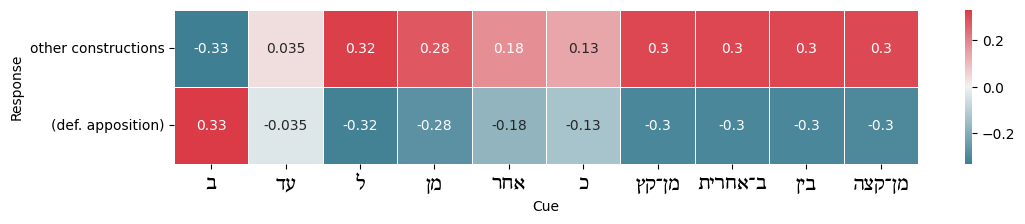

In [47]:
fig, ax = plt.subplots(figsize=(12, 2))

heatmap(
    get_display_df(preplex_defappo['dp1'].iloc[:10, :]).T,
    square=False,
    annot=True,
)

set_labels(ax, axis='x')
ax.set_xlabel('Cue')

ax.set_ylabel('Response')
ax.set_yticklabels(['other constructions', '(def. apposition)'], rotation=0)

if EXPORT_NEW_PLOTS:
    plt.savefig(
        format_plot_fname('test2_dp1'),
        format='pdf',
        bbox_inches='tight',
    )

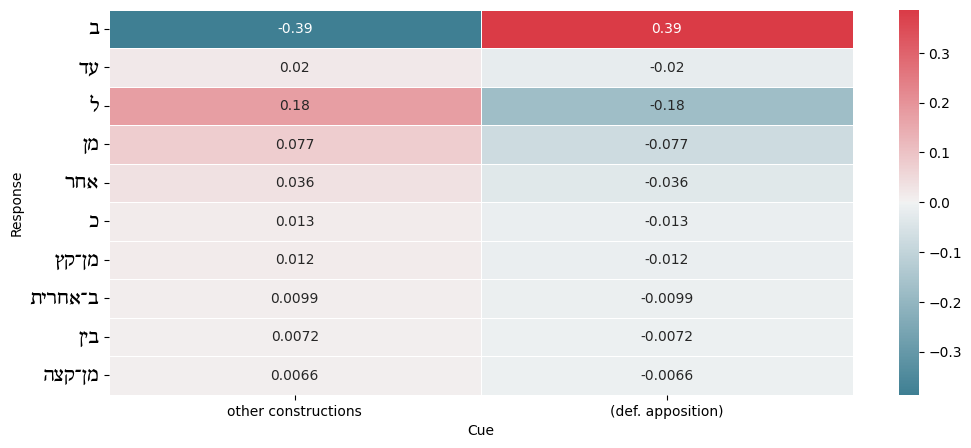

In [48]:
fig, ax = plt.subplots(figsize=(12, 5))

heatmap(
    get_display_df(preplex_defappo['dp2'].iloc[:, :10], 'columns').T,
    square=False,
    annot=True,
)

set_labels(ax, 'y')
ax.set_xlabel('Cue')
ax.set_xticklabels(['other constructions', '(def. apposition)'], rotation=0)
ax.set_ylabel('Response')

if EXPORT_NEW_PLOTS:
    plt.savefig(
        format_plot_fname('test2_dp2'),
        format='pdf',
        bbox_inches='tight',
    )

## Association Test 3: (head x appositive) in def_apposition in time adverbials

pivot

appo_head_cat,demon_far,ordn,demon_near,adjv
head_lex,,,,
יום,239.0,107.0,21.0,2.0
עת,61.0,0.0,1.0,0.0
שׁנה,7.0,36.0,1.0,0.0
חדשׁ,0.0,38.0,1.0,0.0
לילה,16.0,0.0,2.0,0.0
פעם,0.0,1.0,3.0,0.0


prop1

appo_head_cat,demon_far,ordn,demon_near,adjv
head_lex,,,,
יום,0.647696,0.289973,0.056911,0.00542
עת,0.983871,0.000000,0.016129,0.00000
שׁנה,0.159091,0.818182,0.022727,0.00000
חדשׁ,0.000000,0.974359,0.025641,0.00000
לילה,0.888889,0.000000,0.111111,0.00000
פעם,0.000000,0.250000,0.750000,0.00000


prop2

head_lex,יום,עת,שׁנה,חדשׁ,לילה,פעם
appo_head_cat,,,,,,
demon_far,0.739938,0.188854,0.021672,0.000000,0.049536,0.000000
ordn,0.587912,0.000000,0.197802,0.208791,0.000000,0.005495
demon_near,0.724138,0.034483,0.034483,0.034483,0.068966,0.103448
adjv,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


dp1

appo_head_cat,demon_far,ordn,demon_near,adjv
head_lex,,,,
יום,0.144702,-0.159129,0.009006,0.005420
עת,0.431128,-0.383966,-0.042943,-0.004219
שׁנה,-0.483186,0.521434,-0.034183,-0.004065
חדשׁ,-0.649899,0.684621,-0.030697,-0.004024
לילה,0.296225,-0.351351,0.058988,-0.003861
פעם,-0.607143,-0.090226,0.701128,-0.003759


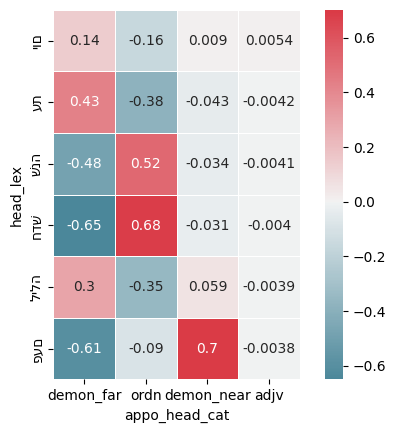

dp2

head_lex,יום,עת,שׁנה,חדשׁ,לילה,פעם
appo_head_cat,,,,,,
demon_far,0.129609,0.184160,-0.152037,-0.183099,0.040146,-0.018779
ordn,-0.152201,-0.175141,0.175203,0.205966,-0.050847,-0.002980
demon_near,0.037747,-0.085833,-0.050330,-0.040468,0.037407,0.101476
adjv,0.312734,-0.116105,-0.082397,-0.073034,-0.033708,-0.007491


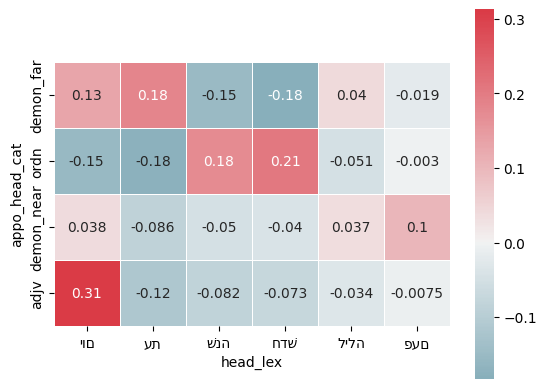

In [49]:
head_appo = run_analysis(
    df[
        (df.PP == 'ב')
        & (df.is_appo == 1)
        & (df.function == 'Time')
    ],
    index=['head_lex'],
    columns=['appo_head_cat'],
    sort_by_cols=True,
    sort_by_rows=True,
)

In [50]:
head_appo['pivot'].astype(int).to_clipboard()

In [51]:
head_appo['pivot'].loc['יום'].sum()

369.0

In [52]:
head_appo['pivot']

appo_head_cat,demon_far,ordn,demon_near,adjv
head_lex,,,,
יום,239.0,107.0,21.0,2.0
עת,61.0,0.0,1.0,0.0
שׁנה,7.0,36.0,1.0,0.0
חדשׁ,0.0,38.0,1.0,0.0
לילה,16.0,0.0,2.0,0.0
פעם,0.0,1.0,3.0,0.0


In [53]:
head_appo['pivot']['demon_far'].sum()

323.0

In [54]:
head_appo['prop1'].loc['יום']

appo_head_cat
demon_far     0.647696
ordn          0.289973
demon_near    0.056911
adjv          0.005420
Name: יום, dtype: float64

In [55]:
head_appo['prop1'].loc['עת']

appo_head_cat
demon_far     0.983871
ordn          0.000000
demon_near    0.016129
adjv          0.000000
Name: עת, dtype: float64

In [56]:
head_appo['prop2'].loc['demon_far']

head_lex
יום     0.739938
עת      0.188854
שׁנה     0.021672
חדשׁ     0.000000
לילה    0.049536
פעם     0.000000
Name: demon_far, dtype: float64

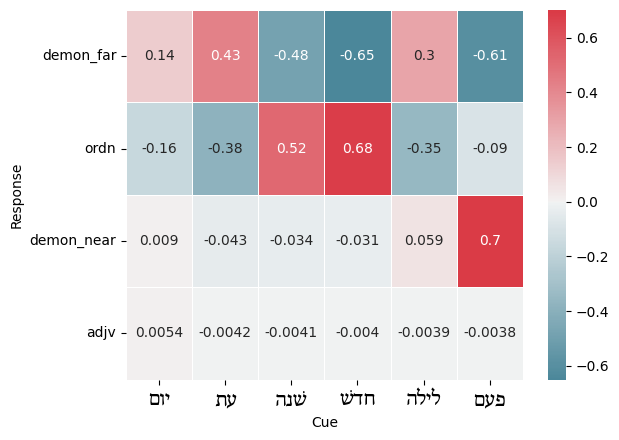

In [58]:
fig, ax = plt.subplots() #figsize=(5, 8))

heatmap(
    get_display_df(head_appo['dp1']).T,
    square=False,
    annot=True,
)

ax.set_xlabel('Cue')
set_labels(ax, axis='x')
ax.set_ylabel('Response')
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
)

if EXPORT_NEW_PLOTS:
    plt.savefig(
        format_plot_fname('test3_dp1'),
        format='pdf',
        bbox_inches='tight',
    )

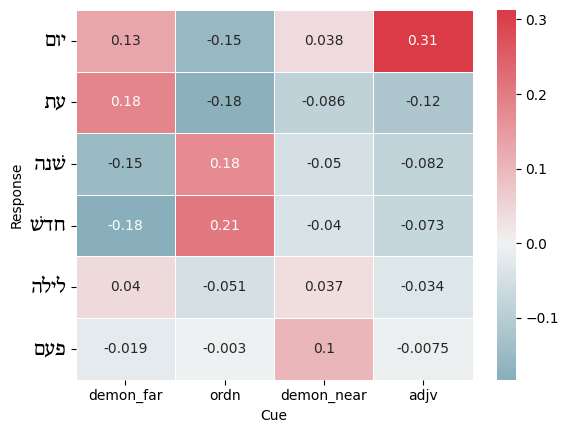

In [59]:
fig, ax = plt.subplots() #figsize=(5, 8))

heatmap(
    get_display_df(head_appo['dp2'], 'columns').T,
    square=False,
    annot=True,
)

ax.set_xlabel('Cue')


ax.set_ylabel('Response')
set_labels(ax, 'y')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


if EXPORT_NEW_PLOTS:
    plt.savefig(
        format_plot_fname('test3_dp2'),
        format='pdf',
        bbox_inches='tight',
    )

## Association Test 4: (prep lex x head)

pivot

head_lex,יום,עת,לילה,שׁנה
PP,,,,
ב,239.0,61.0,16.0,7.0
עד,4.0,2.0,0.0,0.0
מן,1.0,1.0,0.0,0.0
אחר,1.0,0.0,0.0,0.0
ל־פנה,1.0,0.0,0.0,0.0


prop1

head_lex,יום,עת,לילה,שׁנה
PP,,,,
ב,0.739938,0.188854,0.049536,0.021672
עד,0.666667,0.333333,0.000000,0.000000
מן,0.500000,0.500000,0.000000,0.000000
אחר,1.000000,0.000000,0.000000,0.000000
ל־פנה,1.000000,0.000000,0.000000,0.000000


prop2

PP,ב,עד,מן,אחר,ל־פנה
head_lex,,,,,
יום,0.971545,0.01626,0.004065,0.004065,0.004065
עת,0.953125,0.03125,0.015625,0.000000,0.000000
לילה,1.000000,0.00000,0.000000,0.000000,0.000000
שׁנה,1.000000,0.00000,0.000000,0.000000,0.000000


dp1

head_lex,יום,עת,לילה,שׁנה
PP,,,,
ב,0.039938,-0.111146,0.049536,0.021672
עד,-0.073394,0.143731,-0.048930,-0.021407
מן,-0.240181,0.309668,-0.048338,-0.021148
אחר,0.262048,-0.192771,-0.048193,-0.021084
ל־פנה,0.262048,-0.192771,-0.048193,-0.021084


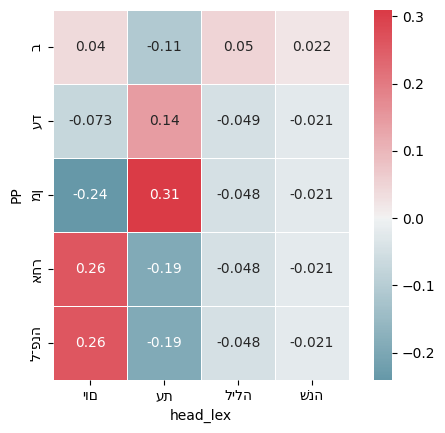

dp2

PP,ב,עד,מן,אחר,ל־פנה
head_lex,,,,,
יום,0.006027,-0.006728,-0.007429,0.004065,0.004065
עת,-0.020853,0.016380,0.011908,-0.003717,-0.003717
לילה,0.031546,-0.018927,-0.006309,-0.003155,-0.003155
שׁנה,0.030675,-0.018405,-0.006135,-0.003067,-0.003067


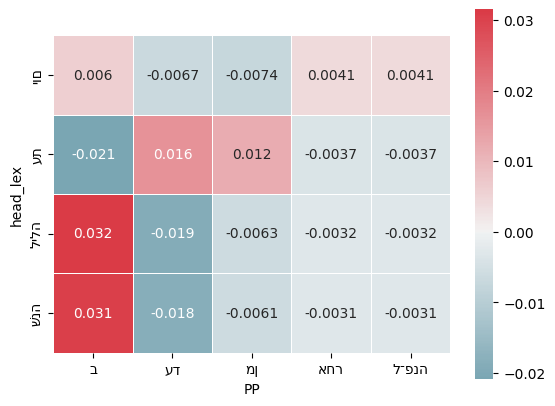

In [60]:
preplex_head = run_analysis(
    df[
        (df.is_appo == 1)
        & (df.PP_bin == 1)
        & (df.function == 'Time')
        & (df.appo_head_cat == 'demon_far')
    ],
    index=['PP'],
    columns=['head_lex'],
    sort_by_cols=True,
    sort_by_rows=True,
)

In [61]:
preplex_head['prop1'].loc['ב']

head_lex
יום     0.739938
עת      0.188854
לילה    0.049536
שׁנה     0.021672
Name: ב, dtype: float64

In [62]:
preplex_head['pivot'].loc['ב'].sum()

323.0

In [63]:
preplex_head['prop2'].loc['יום']

PP
ב        0.971545
עד       0.016260
מן       0.004065
אחר      0.004065
ל־פנה    0.004065
Name: יום, dtype: float64

In [64]:
preplex_head['pivot']['יום'].sum()

246.0

In [65]:
preplex_head['pivot'].astype(int).to_clipboard()

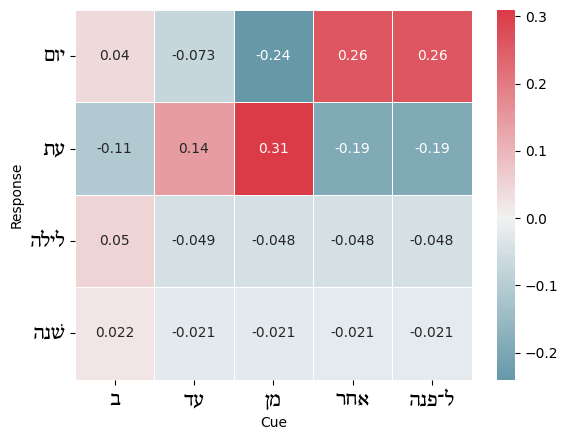

In [66]:
fig, ax = plt.subplots() #figsize=(5, 8))

heatmap(
    get_display_df(
        get_display_df(preplex_head['dp1'], 'index'),
        'columns'
    ).T,
    square=False,
    annot=True,
)

ax.set_xlabel('Cue')
set_labels(ax, 'x')

ax.set_ylabel('Response')
set_labels(ax, 'y')

if EXPORT_NEW_PLOTS:
    plt.savefig(
        format_plot_fname('test4_dp1'),
        format='pdf',
        bbox_inches='tight',
    )

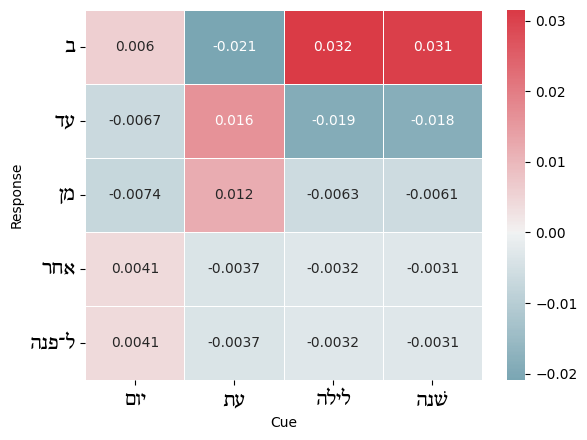

In [67]:
fig, ax = plt.subplots() #figsize=(5, 8))

heatmap(
    get_display_df(
        get_display_df(preplex_head['dp2'], 'columns'),
        'index'
    ).T,
    square=False,
    annot=True,
)

ax.set_xlabel('Cue')
set_labels(ax, 'x')
ax.set_ylabel('Response')
set_labels(ax, 'y')

if EXPORT_NEW_PLOTS:
    plt.savefig(
        format_plot_fname('test4_dp2'),
        format='pdf',
        bbox_inches='tight',
    )

## Analysis of Results

In [68]:
head_appo['dp1'].head()

appo_head_cat,demon_far,ordn,demon_near,adjv
head_lex,,,,
יום,0.144702,-0.159129,0.009006,0.005420
עת,0.431128,-0.383966,-0.042943,-0.004219
שׁנה,-0.483186,0.521434,-0.034183,-0.004065
חדשׁ,-0.649899,0.684621,-0.030697,-0.004024
לילה,0.296225,-0.351351,0.058988,-0.003861


In [70]:
B = 'ב'
JWM = 'יום'

JWM_REV = algorithm.get_display(JWM)

analysis_data = [
    # T1
    ('time adverbial function → (prep. + def. apposition)', isappo_function['dp1'].loc[1, 'Time']),
    ('(prep. + def. apposition) → time adverbial function', isappo_function['dp2'].loc['Time', 1]),
    
    # T2
    (f'{B} → def. apposition', preplex_defappo['dp1'].loc[B, 1]),
    (f'def. apposition → {B}', preplex_defappo['dp2'].loc[1, B]),
    
    # T3
    (f'{JWM_REV} → demonstrative far', head_appo['dp1'].loc[JWM, 'demon_far']),
    (f'demonstrative far → {JWM_REV}', head_appo['dp2'].loc['demon_far', JWM]),
    
    # T4
        # NB: backwards str. so it prints correctly
    (f'{B} → {JWM_REV}', preplex_head['dp1'].loc[B, JWM]),
    (f'{JWM_REV} → {B}', preplex_head['dp2'].loc[JWM, B]),
]

# analysis_data = [
#     (algorithm.get_display(index_str), val) for index_str, val in analysis_data
# ] 

In [71]:
analysis_data

[('time adverbial function → (prep. + def. apposition)', 0.3774066214531944),
 ('(prep. + def. apposition) → time adverbial function', 0.277720293742558),
 ('ב → def. apposition', 0.32857676852630596),
 ('def. apposition → ב', 0.386788792284445),
 ('םוי → demonstrative far', 0.14470246498872175),
 ('demonstrative far → םוי', 0.1296094419977034),
 ('ב → םוי', 0.039938080495356076),
 ('םוי → ב', 0.006027474067844096)]

In [72]:
test = pd.DataFrame(analysis_data)
test.index = test[0]
test.drop(0, inplace=True, axis=1)
test = test.sort_values(by=1, ascending=False)

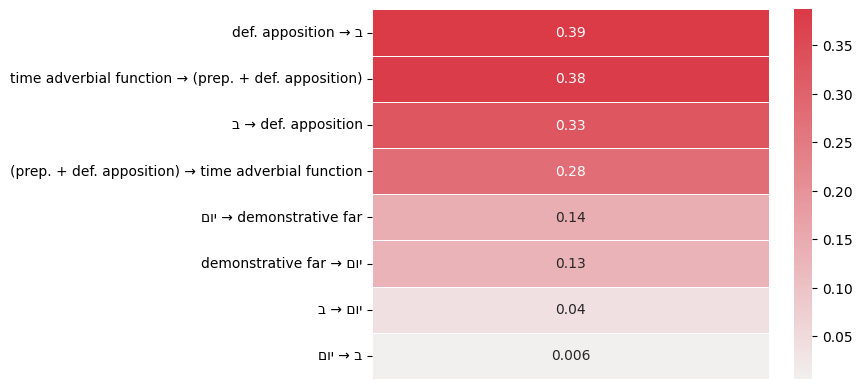

In [73]:
fig, ax = plt.subplots()

heatmap(
    test,
    ax=ax,
    square=False,
    annot=True,
)

ax.set_ylabel('')
ax.set_xlabel('')
ax.tick_params(
    bottom=False,
)
_ = ax.set_xticklabels([])


if EXPORT_NEW_PLOTS:
    plt.savefig(
        format_plot_fname('analysis_heatmap'),
        format='pdf',
        bbox_inches='tight',
    )

# Textual Examples

## Past & Future Examples

In [201]:
import subprocess 

def copy_to_clipboard(data):
    subprocess.run("pbcopy", universal_newlines=True, input=data)

In [202]:
def get_verse(section):
    node = T.nodeFromSection(section)
    copy_to_clipboard(T.text(node))

In [205]:
get_verse(('Genesis', 1, 1))

In [208]:
get_verse(('Judges', 3, 30))

In [209]:
get_verse(('Esther', 5, 9))

In [210]:
get_verse(('Joshua', 14, 9))

In [211]:
get_verse(('Nehemiah', 12, 43))

In [212]:
get_verse(('Exodus', 8, 18))

In [213]:
get_verse(('Deuteronomy', 31, 17))

In [214]:
get_verse(('Isaiah', 2, 20))

In [215]:
get_verse(('Isaiah', 27, 2))

In [216]:
get_verse(('Jeremiah', 25, 33))

In [217]:
get_verse(('Ezekiel', 24, 26))

In [218]:
get_verse(('Zechariah', 2, 15))

In [219]:
get_verse(('Zechariah', 3, 10))

In [220]:
get_verse(('Zechariah', 12, 11))

In [221]:
get_verse(('Isaiah', 7, 23))

In [222]:
get_verse(('Isaiah', 31, 7))

## slot filler examples

In [223]:
df.columns

Index(['ph_node', 'ref', 'book', 'ph_text', 'verse_text', 'function',
       'clause_node', 'clause_text', 'PP', 'PP_bin', 'is_appo', 'head_lex',
       'appo_head_lex', 'appo_head_pdp', 'appo_head_cat'],
      dtype='object')

In [225]:
df[df.appo_head_cat == 'ordn'].sample(5)

,ph_node,ref,book,ph_text,verse_text,function,clause_node,clause_text,PP,PP_bin,is_appo,head_lex,appo_head_lex,appo_head_pdp,appo_head_cat
25830,756024,1_Kings 6:38,1_Kings,הַחֹ֣דֶשׁ הַשְּׁמִינִ֔י,וּבַשָּׁנָה֩ הָאַחַ֨ת עֶשְׂרֵ֜ה בְּיֶ֣רַח בּ֗ו...,PreC,462020,ה֚וּא הַחֹ֣דֶשׁ הַשְּׁמִינִ֔י,Ø,0,1,חדשׁ,שׁמיני,adjv,ordn
16736,718593,Joshua 9:17,Joshua,בַּיֹּ֣ום הַשְּׁלִישִׁ֑י,וַיִּסְע֣וּ בְנֵֽי־יִשְׂרָאֵ֗ל וַיָּבֹ֛אוּ אֶל...,Time,449664,וַיָּבֹ֛אוּ אֶל־עָרֵיהֶ֖ם בַּיֹּ֣ום הַשְּׁלִיש...,ב,1,1,יום,שׁלישׁי,adjv,ordn
18479,725058,Judges 6:26,Judges,אֶת־הַפָּ֣ר הַשֵּׁנִ֔י,וּבָנִ֨יתָ מִזְבֵּ֜חַ לַיהוָ֣ה אֱלֹהֶ֗יךָ עַ֣ל...,Objc,451799,וְלָֽקַחְתָּ֙ אֶת־הַפָּ֣ר הַשֵּׁנִ֔י,את,1,1,פר,שׁני,adjv,ordn
30280,774029,2_Kings 25:25,2_Kings,בַּחֹ֣דֶשׁ הַשְּׁבִיעִ֗י,וַיְהִ֣י׀ בַּחֹ֣דֶשׁ הַשְּׁבִיעִ֗י בָּ֣א יִשְׁ...,Time,468115,וַיְהִ֣י׀ בַּחֹ֣דֶשׁ הַשְּׁבִיעִ֗י,ב,1,1,חדשׁ,שׁביעי,adjv,ordn
21088,736132,1_Samuel 14:14,1_Samuel,הַמַּכָּ֣ה הָרִאשֹׁנָ֗ה,וַתְּהִ֞י הַמַּכָּ֣ה הָרִאשֹׁנָ֗ה אֲשֶׁ֨ר הִכּ...,Subj,455431,וַתְּהִ֞י הַמַּכָּ֣ה הָרִאשֹׁנָ֗ה כְּעֶשְׂרִ֣י...,Ø,0,1,מכה,ראשׁון,adjv,ordn


In [226]:
df[df.appo_head_cat == 'demon_far'].sample(5)

,ph_node,ref,book,ph_text,verse_text,function,clause_node,clause_text,PP,PP_bin,is_appo,head_lex,appo_head_lex,appo_head_pdp,appo_head_cat
20470,733556,1_Samuel 6:16,1_Samuel,בַּיֹּ֥ום הַהֽוּא׃ ס,וַחֲמִשָּׁ֥ה סַרְנֵֽי־פְלִשְׁתִּ֖ים רָא֑וּ וַי...,Time,454595,וַיָּשֻׁ֥בוּ עֶקְרֹ֖ון בַּיֹּ֥ום הַהֽוּא׃ ס,ב,1,1,יום,הוא,prde,demon_far
16281,716871,Joshua 5:2,Joshua,בָּעֵ֣ת הַהִ֗יא,בָּעֵ֣ת הַהִ֗יא אָמַ֤ר יְהוָה֙ אֶל־יְהֹושֻׁ֔עַ...,Time,449109,בָּעֵ֣ת הַהִ֗יא אָמַ֤ר יְהוָה֙ אֶל־יְהֹושֻׁ֔עַ,ב,1,1,עת,היא,prde,demon_far
53388,875169,Esther 6:1,Esther,בַּלַּ֣יְלָה הַה֔וּא,בַּלַּ֣יְלָה הַה֔וּא נָדְדָ֖ה שְׁנַ֣ת הַמֶּ֑לֶ...,Time,505657,בַּלַּ֣יְלָה הַה֔וּא נָדְדָ֖ה שְׁנַ֣ת הַמֶּ֑לֶךְ,ב,1,1,לילה,הוא,prde,demon_far
9372,690446,Leviticus 23:30,Leviticus,אֶת־הַנֶּ֥פֶשׁ הַהִ֖וא,וְכָל־הַנֶּ֗פֶשׁ אֲשֶׁ֤ר תַּעֲשֶׂה֙ כָּל־מְלָא...,Objc,440356,וְהַֽאֲבַדְתִּ֛י אֶת־הַנֶּ֥פֶשׁ הַהִ֖וא מִקֶּ֥...,את,1,1,נפשׁ,היא,prde,demon_far
44155,834283,Zechariah 14:4,Zechariah,בַּיֹּום־הַ֠הוּא,וְעָמְד֣וּ רַגְלָ֣יו בַּיֹּום־הַ֠הוּא עַל־הַ֨ר...,Time,489855,וְעָמְד֣וּ רַגְלָ֣יו בַּיֹּום־הַ֠הוּא עַל־הַ֨ר...,ב,1,1,יום,הוא,prde,demon_far


In [228]:
df[(df.appo_head_cat == 'demon_near') & (df.function == 'Time')].sample(5)

,ph_node,ref,book,ph_text,verse_text,function,clause_node,clause_text,PP,PP_bin,is_appo,head_lex,appo_head_lex,appo_head_pdp,appo_head_cat
16445,717440,Joshua 6:25,Joshua,עַ֖ד הַיֹּ֣ום הַזֶּ֑ה,וְֽאֶת־רָחָ֣ב הַ֠זֹּונָה וְאֶת־בֵּ֨ית אָבִ֤יהָ...,Time,449292,וַתֵּ֨שֶׁב֙ בְּקֶ֣רֶב יִשְׂרָאֵ֔ל עַ֖ד הַיֹּ֣ו...,עד,1,1,יום,זה,prde,demon_near
21442,737662,1_Samuel 17:10,1_Samuel,הַיֹּ֣ום הַזֶּ֑ה,וַיֹּ֨אמֶר֙ הַפְּלִשְׁתִּ֔י אֲנִ֗י חֵרַ֛פְתִּי...,Time,455950,אֲנִ֗י חֵרַ֛פְתִּי אֶת־מַעַרְכֹ֥ות יִשְׂרָאֵ֖ל...,Ø,0,1,יום,זה,prde,demon_near
32228,782440,Isaiah 39:6,Isaiah,עַד־הַיֹּ֥ום הַזֶּ֖ה,הִנֵּה֮ יָמִ֣ים בָּאִים֒ וְנִשָּׂ֣א׀ כָּל־אֲשׁ...,Time,471191,וַאֲשֶׁ֨ר אָצְר֧וּ אֲבֹתֶ֛יךָ עַד־הַיֹּ֥ום הַז...,עד,1,1,יום,זה,prde,demon_near
22725,743568,1_Samuel 30:25,1_Samuel,עַ֖ד הַיֹּ֥ום הַזֶּֽה׃ פ,וַיְהִ֕י מֵֽהַיֹּ֥ום הַה֖וּא וָמָ֑עְלָה וַיְשׂ...,Time,457881,וַיְשִׂמֶ֜הָ לְחֹ֤ק וּלְמִשְׁפָּט֙ לְיִשְׂרָאֵ...,עד,1,1,יום,זה,prde,demon_near
29813,772407,2_Kings 20:17,2_Kings,עַד־הַיֹּ֥ום הַזֶּ֖ה,הִנֵּה֮ יָמִ֣ים בָּאִים֒ וְנִשָּׂ֣א׀ כָּל־אֲשׁ...,Time,467598,וַאֲשֶׁ֨ר אָצְר֧וּ אֲבֹתֶ֛יךָ עַד־הַיֹּ֥ום הַז...,עד,1,1,יום,זה,prde,demon_near


In [230]:
df[(df.appo_head_cat == 'adjv') & (df.function == 'Time')]

,ph_node,ref,book,ph_text,verse_text,function,clause_node,clause_text,PP,PP_bin,is_appo,head_lex,appo_head_lex,appo_head_pdp,appo_head_cat
3966,670045,Exodus 2:23,Exodus,בַיָּמִ֨ים הָֽרַבִּ֜ים הָהֵ֗ם,וַיְהִי֩ בַיָּמִ֨ים הָֽרַבִּ֜ים הָהֵ֗ם וַיָּ֨מ...,Time,433720,וַיְהִי֩ בַיָּמִ֨ים הָֽרַבִּ֜ים הָהֵ֗ם,ב,1,1,יום,רב,adjv,adjv
18606,725623,Judges 7:19,Judges,רֹ֚אשׁ הָאַשְׁמֹ֣רֶת הַתִּֽיכֹונָ֔ה,וַיָּבֹ֣א גִ֠דְעֹון וּמֵאָה־אִ֨ישׁ אֲשֶׁר־אִתּ...,Time,451986,וַיָּבֹ֣א גִ֠דְעֹון וּמֵאָה־אִ֨ישׁ בִּקְצֵ֣ה ה...,ראשׁ,1,1,אשׁמרת,תיכון,adjv,adjv
28397,766798,2_Kings 6:29,2_Kings,בַּיֹּ֣ום הָאַחֵ֗ר,וַנְּבַשֵּׁ֥ל אֶת־בְּנִ֖י וַנֹּֽאכְלֵ֑הוּ וָאֹ...,Time,465717,וָאֹמַ֨ר אֵלֶ֜יהָ בַּיֹּ֣ום הָאַחֵ֗ר,ב,1,1,יום,אחר,adjv,adjv
52144,870275,Ecclesiastes 2:16,Ecclesiastes,הַיָּמִ֤ים הַבָּאִים֙,כִּי֩ אֵ֨ין זִכְרֹ֧ון לֶחָכָ֛ם עִֽם־הַכְּסִ֖יל...,Time,503897,בְּשֶׁכְּבָ֞ר הַיָּמִ֤ים הַבָּאִים֙ הַכֹּ֣ל נִ...,Ø,0,1,יום,בוא,adjv,adjv


## Moshavi's cases

In [234]:
in_the_year = bhsa.search('''

phrase
    word lex=B
    <: word lex=CNH/ st=c
    <: word

''')

  0.56s 84 results


In [236]:
# bhsa.show(in_the_year)

In [243]:
in_the_month = bhsa.search('''

phrase
    word lex=B
    <: word lex=XDC=/

''')

  0.41s 10 results


In [245]:
# bhsa.show(in_the_month)